<a href="https://colab.research.google.com/github/amitrappel/Experimentation/blob/master/Hybrid_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from datetime import datetime
import backtrader as bt
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

%matplotlib inline

In [1]:
!pip install backtrader[plotting]
!pip install yfinance

     |████████████████████████████████| 419kB 2.7MB/s 
     |████████████████████████████████| 5.5MB 5.2MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22618 sha256=3bfa57d46203577a889251f8f085c69f0f056540dd43673ca725c297491c5be1
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


# Get the data

In [4]:
df = pd.read_csv('all_stocks_last_400.csv')
df['dt'] = pd.to_datetime(df['Date'])
df.drop(['Date', 'Dividends', 'Stock Splits', 'Adj Close'], axis=1, inplace=True)
df = df[df['dt'].dt.year == 2019]
df.sample(5)

,Open,High,Low,Close,Volume,Symbol,dt
21380,115.98,117.35,113.84,117.05,694900.0,AIZ,2019-08-08
38668,418.97,423.92,415.97,421.34,1367700.0,CHTR,2019-09-10
54542,23.57,24.28,23.21,23.99,7706100.0,DVN,2019-09-12
30540,128.25,129.36,128.12,128.53,507800.0,BR,2019-06-12
35099,51.82,52.39,51.73,52.37,945000.0,CBRE,2019-10-23


In [5]:
def get_yearly_return(df_symbol):
    return 100*(df_symbol['Close'].iloc[-1] - df_symbol['Open'].iloc[0]) / df_symbol['Open'].iloc[0]

In [6]:
stocks = df.groupby('Symbol').apply(get_yearly_return)
stocks_df = stocks.sort_values().dropna().reset_index().reset_index()
stocks_df.columns = ['Index','Symbol','Returns']
stocks_df['Rank'] = (stocks_df['Index'] / 100).astype(int)
stocks_df.sample(5)

,Index,Symbol,Returns,Rank
113,113,ABT,25.444218,1
220,220,ACN,53.476407,2
53,53,CTXS,11.847043,0
247,247,HES,72.896461,2
193,193,CERN,43.681102,1


In [7]:
stocks_df.groupby('Rank')['Returns'].mean()

Rank
0     8.025662
1    33.710500
2    64.511627
Name: Returns, dtype: float64

In [11]:
rank = 2
stock = stocks_df[stocks_df['Rank'] == rank].sample()['Symbol'].values[0]
stock

'FTNT'

In [12]:
# out_file_name = f'SMA{fast}-{slow}_stock_{stock}_rank_{rank}.csv'

In [13]:
contract = yf.Ticker(stock)
contract_history = contract.history(start ='2019-01-01',
                                    end='2020-01-01',  
                                    interval='1d')
data_pd = bt.feeds.PandasData(dataname=contract_history)

# Strategies

In [14]:
class TestStrategy(bt.Strategy):

    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close

        # To keep track of pending orders
        self.order = None

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log('BUY EXECUTED, %.2f' % order.executed.price)
            elif order.issell():
                self.log('SELL EXECUTED, %.2f' % order.executed.price)

            self.bar_executed = len(self)

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        self.order = None

    def next(self):
        # Simply log the closing price of the series from the reference
        # self.log('Close, %.2f' % self.dataclose[0])

        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        # Check if we are in the market
        if not self.position:

            # Not yet ... we MIGHT BUY if ...
            if self.dataclose[0] < self.dataclose[-1]:
                    # current close less than previous close

                    if self.dataclose[-1] < self.dataclose[-2]:
                        # previous close less than the previous close

                        # BUY, BUY, BUY!!! (with default parameters)
                        self.log('BUY CREATE, %.2f' % self.dataclose[0])

                        # Keep track of the created order to avoid a 2nd order
                        self.order = self.buy()

        else:

            # Already in the market ... we might sell
            if len(self) >= (self.bar_executed + 5):
                # SELL, SELL, SELL!!! (with all possible default parameters)
                self.log('SELL CREATE, %.2f' % self.dataclose[0])

                # Keep track of the created order to avoid a 2nd order
                self.order = self.sell()

In [15]:
class SmaCross(bt.SignalStrategy):
    params = (('fast',10),
              ('slow',30),
             )
    def __init__(self):
        self.sma_fast = bt.ind.SMA(period=self.params.fast)
        self.sma_slow = bt.ind.SMA(period=self.params.slow)

    def start(self):
        pass

    
    def next(self):
        if self.position.size == 0:
            if self.sma_fast  > self.sma_slow:
                self.buy()
        elif self.position.size != 0:
            if self.sma_fast < self.sma_slow:
                self.sell()

    def stop(self):
        pass 
        
    def notify_order(self, order):
        if order.status in [order.Completed]:
            if order.isbuy():
                pass
            else:  # Sell
                pass        

In [16]:
fast = 10
slow = 30

# Cerebro

In [18]:
cerebro = bt.Cerebro()
cerebro.addstrategy(SmaCross, fast=fast, slow = slow)
cerebro.addstrategy(TestStrategy)
cerebro.adddata(data_pd)
cerebro.addsizer(bt.sizers.PercentSizer, percents = 90)
# cerebro.addwriter(bt.WriterFile, out=None ,csv=True)
cerebro.broker.setcash(100000)
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
cerebro.run()
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
2019-01-02, BUY CREATE, 69.68
2019-01-03, BUY EXECUTED, 68.80
2019-01-10, SELL CREATE, 73.21
2019-01-11, SELL EXECUTED, 72.99
2019-01-22, BUY CREATE, 69.85
2019-01-23, BUY EXECUTED, 70.29
2019-01-30, SELL CREATE, 75.16
2019-01-31, SELL EXECUTED, 75.25
2019-02-07, BUY CREATE, 79.36
2019-02-08, BUY EXECUTED, 78.64
2019-02-15, SELL CREATE, 83.11
2019-02-19, SELL EXECUTED, 83.02
2019-02-26, SELL CREATE, 86.98
2019-02-27, SELL EXECUTED, 87.48
2019-03-06, SELL CREATE, 82.90
2019-03-07, SELL EXECUTED, 82.91
2019-03-07, BUY CREATE, 82.48
2019-03-08, Order Canceled/Margin/Rejected
2019-03-14, SELL CREATE, 84.38
2019-03-15, SELL EXECUTED, 84.48
2019-03-25, SELL CREATE, 85.02
2019-03-26, SELL EXECUTED, 85.89
2019-03-26, BUY CREATE, 84.84
2019-03-27, Order Canceled/Margin/Rejected
2019-04-02, SELL CREATE, 85.63
2019-04-03, SELL EXECUTED, 86.11
2019-04-10, SELL CREATE, 89.62
2019-04-11, SELL EXECUTED, 90.00
2019-04-18, SELL CREATE, 91.08
2019-04-22, SELL EXECUTED

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

[[<Figure size 432x288 with 4 Axes>], [<Figure size 432x288 with 4 Axes>]]

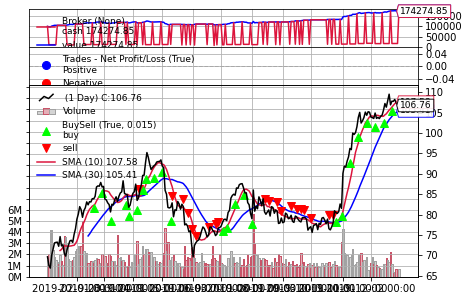

In [21]:
cerebro.plot()[0][0]

In [17]:
for fast in [3, 5, 10]:
    for slow in [10, 15, 20, 30]:
        if fast < slow:
            print(fast, slow)
            cerebro = bt.Cerebro()
            cerebro.addstrategy(SmaCross, fast=fast, slow = slow)
            cerebro.addstrategy(TestStrategy)
            cerebro.adddata(data_pd)
            cerebro.addsizer(bt.sizers.PercentSizer, percents = 90)
            # cerebro.addwriter(bt.WriterFile, out=None ,csv=True)
            cerebro.broker.setcash(100000)
            print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
            cerebro.run()
            print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
# cerebro.plot()

3 10
Starting Portfolio Value: 100000.00
2019-01-02, BUY CREATE, 69.68
2019-01-03, BUY EXECUTED, 68.80
2019-01-10, SELL CREATE, 73.21
2019-01-11, SELL EXECUTED, 72.99
2019-01-18, SELL CREATE, 70.50
2019-01-22, SELL EXECUTED, 69.00
2019-01-29, SELL CREATE, 73.21
2019-01-30, SELL EXECUTED, 73.92
2019-02-06, SELL CREATE, 81.22
2019-02-07, SELL EXECUTED, 81.00
2019-02-14, SELL CREATE, 83.19
2019-02-15, SELL EXECUTED, 83.35
2019-02-25, SELL CREATE, 87.06
2019-02-26, SELL EXECUTED, 86.76
2019-03-05, SELL CREATE, 83.62
2019-03-06, SELL EXECUTED, 83.73
2019-03-13, SELL CREATE, 83.66
2019-03-14, SELL EXECUTED, 83.62
2019-03-21, SELL CREATE, 88.30
2019-03-22, SELL EXECUTED, 88.00
2019-03-29, SELL CREATE, 83.97
2019-04-01, SELL EXECUTED, 84.59
2019-04-08, SELL CREATE, 86.08
2019-04-09, SELL EXECUTED, 85.47
2019-04-16, SELL CREATE, 94.05
2019-04-17, SELL EXECUTED, 94.37
2019-04-25, SELL CREATE, 92.90
2019-04-26, SELL EXECUTED, 93.00
2019-05-03, SELL CREATE, 85.96
2019-05-06, SELL EXECUTED, 83.65
2